# Analyze A/B Test Results 

- Introduction
- Part I - Probability
- Part II - A/B Test
- Part III - Regression


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  We will help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure we get the same answers to answer questions as part of the nanodegree
random.seed(42)

### To Do 1.1
Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>


**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


It looks like the users have been recorded with a unique ID and the time they looked at the website. We can then see if that user was part of the control group who were shown the old page, or the treatment group who were shown the new landing page. We can then see if each user was converted into a customer. Let's look at the data in a bit more detail.

**b.** Find the number of rows in the dataset.

In [3]:
#output the number of rows in the dataframe
df.shape[0]

294478

There are 294478 rows of data in our dataset.

**c.** Find the number of unique users in the dataset.

In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

We have 290584 unique user ID's.

**d.** Find the proportion of users converted.

In [5]:
#Because 'converted' is either a 1 for true of 0 for false, we can use the mean to calcualte the proportion. Then format as a percentage

converted = df['converted'].mean()
"{:.4%}".format(converted)

'11.9659%'

There is an 11.9659% conversion rate.

**e.** Calcuate the number of times the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
#count the times where group is treatment and landing page is not new_page
len(df.query("group == 'treatment' & landing_page != 'new_page'"))

1965

There are 1965 records where the group is treatment but the landing page is not the new page. It would also be useful to know if there are any times where the group is control but the landing page is not the old page.

In [7]:
#count the times where group is control and landing page is not old_page
len(df.query("group == 'control' & landing_page != 'old_page'"))

1928

There are 1928 records where the group is treatment but the landing page is not the new page. We will have to remove the 3893 rows later as we can't be sure which page the user was shown.

**f.** Do any of the rows have missing values?

In [8]:
#count the null values in each column
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

None of the rows have missing data.

### To Do 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


**a.** Create a new dataset that meets these specifications. Store your new dataframe in **df2**.

In [9]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
control_old_page = df.query("group == 'control' and landing_page == 'old_page'")
treatment_new_page = df.query("group == 'treatment' and landing_page == 'new_page'")
df2=control_old_page.append(treatment_new_page)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


There were 294478 rows in the original dataframe but 3893 rows where we couldn't be sure if the user recieved the old or new webpage. So as expected, after removing these rows we have a new dataframe with 290585 rows. Let's double check we don't have an incorrect values:

In [10]:
# Double Check all of the incorrect rows were removed from df2 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### To Do 1.3  


**a.** How many unique **user_id**s are in **df2**?

In [11]:
#count the unique values in each column
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

Our dataframe has 290584 unique user id's, this means that one of the id's is duplicated.

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [12]:
#output the row with the duplicated id
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


The user id 773192 is duplicated

**c.** Display the rows for the duplicate **user_id**? 

In [13]:
#output the rows with the duplicated id
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [14]:
# Remove one of the rows with a duplicate user_id. 
df2 = df2.drop(df2[df2.duplicated(['user_id'])].index)
# Check again if the row with a duplicate user_id is deleted or not
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


There is now only one row with user id 773192 now which is what we want.

### To Do 1.4  
**a.** What is the probability of an individual converting regardless of the page they receive?


In [15]:
#calcualte the overall proportion that is converted 
#again we can use the mean because converted is recorded as 1 or 0
df2['converted'].mean()

0.11959708724499628

The success rate in the population is 0.1196

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
control_df = df2.query("group =='control'")
control_conversion_prob = control_df['converted'].mean()
control_conversion_prob

0.1203863045004612

The conversion rate of the control group is 0.1204

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
treatment_df = df2.query("group =='treatment'")
treatment_conversion_prob = treatment_df['converted'].mean()
treatment_conversion_prob

0.11880806551510564

The conversion rate of the treatment group is 0.1188

Later we will need the difference  (`obs_diff`) between the conversion rates for the two groups. So let's calculate this now: 

In [18]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treatment_conversion_prob-control_conversion_prob
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [19]:
#calculate the probability someone got the new page
new_page_df = df2.query("landing_page =='new_page'")
new_page_prob = new_page_df.shape[0]/df2.shape[0]
new_page_prob

0.5000619442226688

The probability that someone recieved the new landing page is 0.5001

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

It is close to a 50% probability as to wheether users were shown the new page or the old page, but there was only a difference of 0.15% between the conversion rate of people viewing the old page compared to the new page, so it would appear that the new page had no meaningful impact on conversion rates.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, we could run a hypothesis test continuously as long as we observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### To Do 2.1
For now, we will consider we need to make the decision just based on all the data provided.    

$H_{0} : p_{old} \ge p_{new}$

Null hypothesis is that the new page is no better than the old page


$H_{1} : p_{old} < p_{new}$

Alternative hypothesis is that the new page is better than old page


### To Do 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, we'll assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, we'll assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [20]:
#calculate the overall conversion rate
p_new = df2['converted'].mean()
p_new

0.11959708724499628

Under the null hypothesis, the conversion rate for users shown the new page is the same as the overall conversion rate. $p_{new} = 0.1196$

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [21]:
#calculate the overall conversion rate
p_old = df2['converted'].mean()
p_old

0.11959708724499628

Under the null hypothesis, the conversion rate for users shown the old page is the same as the overall conversion rate. $p_{old} = 0.1196$

**c.** What is $n_{new}$, the number of individuals in the treatment group? 

In [22]:
#count the rows where the group is treatment
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

There are 145310 users in the treatment group.

**d.** What is $n_{old}$, the number of individuals in the control group?

In [23]:
#count the rows where the group is treatment
n_old = df2.query('group == "control"').shape[0]
n_old

145274

There are 145274 users in the treatment group.

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis. 

Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [24]:
# Simulate a sample for the treatment Group
new_page_converted = np.random.choice([0,1], n_new, p=[(1-p_new), p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [25]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1], n_old, p=[(1-p_old), p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [26]:
 new_page_converted.mean() - old_page_converted.mean()

-0.00066954293618012861


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [27]:
# Generate random arrays for new and old page converted
new_page_converted = np.random.binomial(n_new, p_new, 10000) / n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000) / n_old

# Calculate the difference in means between new and old page conversions
p_diffs = new_page_converted - old_page_converted

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  


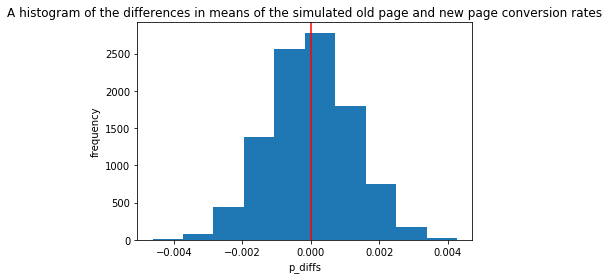

In [28]:
#plot a histagram of the p_diffs
plt.hist(p_diffs)
plt.axvline(0, color='red')
plt.title('A histogram of the differences in means of the simulated old page and new page conversion rates')
plt.xlabel('p_diffs')
plt.ylabel('frequency')
plt.show()


As expected this shows that there is nearly no difference in the conversion rates of the old and new landing pages which agrees with our null hypothesis.

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [29]:
#proportion of p_diffs greater than obs_diff
(np.array(p_diffs) > obs_diff).mean()

0.90669999999999995

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

The value we have calculated is the $p$-value. With a $p$-value of 0.9067 which is more that 0.05 we fail to reject the null hypothesis, so the new page is not likely to cause a difference in click throguh rates.



**Using Built-in Methods for Hypothesis Testing**<br>
**l.** We could also use a built-in to achieve similar results. The built-in method might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [30]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = (df2[(df2['landing_page']=='old_page')&(df2['converted']==1)])['converted'].count()

# number of conversions with the new_page
convert_new = (df2[(df2['landing_page']=='new_page')&(df2['converted']==1)])['converted'].count()

# number of individuals who were shown the old_page
n_old = df2[df2['landing_page']=='old_page']['user_id'].count()

# number of individuals who received new_page
n_new = df2[df2['landing_page']=='new_page']['user_id'].count()



/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in method.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 

It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score and p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normally distributed datasets is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 

For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected if the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---


In [31]:
import statsmodels.api as sm
# complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old],alternative='two-sided')
print(z_score, p_value)

-1.31092419842 0.189883374482


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Seen as our $z$-score is 1.3109 which is less than 1.960 and our $p$-value is 0.1899 which is bigger than 0.05, we fail to reject the null hypothesis. So the results from this test match the results from the previous test that there is no observed improvement in conversion when users are shown the new landing page.

<a id='regression'></a>
### Part III - A regression approach

### To Do 3.1 
In this final part, we will see that the result achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

We are predicting from two possible ourcomes, either conversion or no conversion, so we will use logistic regression.

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [32]:
#dummy variables
df2[['treatment', 'control']] = pd.get_dummies(df2['group'])
#we don't need the control column so we can drop that
df2=df2.drop('control',axis=1)
#rename treatment to ab_page
df2['ab_page'] = df2['treatment']
#instantiate logistic regression model
df2['intercept']= 1
df2.head()


,user_id,timestamp,group,landing_page,converted,treatment,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,1,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,1,1


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [33]:
#Use statsmodels Logit()
logit_mod=sm.Logit(df2['converted'], df2[['intercept', 'treatment']])
#fit the model
results=logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
#summaries the results
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-07-23 17:14 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -2.0038    0.0081  -247.1457  0.0000  -2.0197  -1.9879
treatment     0.0150    0.0114     1.3109  0.1899  -0.0074   0.0374
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  


The $p$-value, in relation to the treatment page, is 0.1899 which is greater than 0.05, so again we fail to reject the null hypothesis which is the same result as our previous tests.There is a difference in the $p$-value between part II and part III because part II is a one tailed test whereas part III is a two tailed test, meaning we are looking for any difference rather than before when we were seeing if the conversion rate for new page was greater than old page.

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Lots of factors will influence the results, it is a good idea to look into these other factors in our regression model. However one assumption we make in multiple linear regression models is that the predictor variables we use are uncorrelated to each other and are only correlated with our responce. If we add more factors to our model which are correlated, this could lead to inacurate hypothesis test results.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 


 Provide the statistical output as well as a written response to answer this question.

In [35]:
# Read the countries.csv
df_countries=pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [36]:
# Join with the df2 dataframe
df_merged=pd.merge(df2,df_countries, on=['user_id'])
df_merged.head()

,user_id,timestamp,group,landing_page,converted,treatment,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,1,US
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,1,US
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,1,1,US
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,1,1,US


In [37]:

# Create the necessary dummy variables
df_merged[['UK', 'US', 'CA']]=pd.get_dummies(df_merged['country'])
df_merged.head()

,user_id,timestamp,group,landing_page,converted,treatment,ab_page,intercept,country,UK,US,CA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,1,US,0,0,1
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,1,US,0,0,1
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,1,1,US,0,0,1
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,1,1,US,0,0,1


In [38]:
lm=sm.Logit(df_merged['converted'], df_merged[['intercept' ,'UK','US']])
#fit the model
results=lm.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-07-23 17:14 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
UK           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
US            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

The $p$-value for UK is 0.4558 and for US it is 0.4558 both of which are bigger than the critical value of 0.05, hence we fail to reject the null hypotheses. So there doesn't appear to be an impact on conversion rates

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 


In [39]:
#create new interaction columns
df_merged['treatment_UK'] = df_merged['ab_page'] * df_merged['UK']
df_merged['treatment_US'] = df_merged['ab_page'] * df_merged['US']
df_merged.head()

,user_id,timestamp,group,landing_page,converted,treatment,ab_page,intercept,country,UK,US,CA,treatment_UK,treatment_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,1,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,1,US,0,0,1,0,0
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,1,US,0,0,1,0,0
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,1,1,US,0,0,1,0,0
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,1,1,US,0,0,1,0,0


In [40]:
#instantiate logistic regression model
logit_mod=sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'US', 'UK', 'treatment_US', 'treatment_UK']])
#fit the model
results=logit_mod.fit()
#get summary statistics
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-07-23 17:14 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
intercept        -2.0070   0.0097 -207.0454 0.0000 -2.0260 -1.9880
ab_page           0.0206   0.0137    1.5052 0.1323 -0.0062  0.0473
US                0.0257   0.0188    1.3634 0.1728 -0.0112  0.0625
UK               -0.0644   0.0384   -1.6788 0.0932 -0.1396  0.0108
treatment_US     -0.0314   0.0266   -1.1807 0.2377 -0.0835  0.0207
treatment_UK      0.0469   0.0538    0.8718 0.3833 -0.0585  0.1523
==================================================================

"""

The $p$-value for all the variables is greated that the critical value of 0.05 therefore we fail to reject the null hypotheses. This means it is unlikely that there is an effect on conversion rates.

<a id='Conclusion'></a>
### Conclusion

During our analysis we performed statistical test to see whether a new landing page increased the likelihood of a user purchasing a product. 

We started by performing an A/B test where our null hypothesis was that the new landing page did not increase the conversion rate. Our aulternative hypothesis was that the old landing page performed the same or better than the new page. The conclusion after this test was that we accepted the null hypothesis. This means that the old landing should be kept as there is no reason to believe the new landing page is better.

Next we fitted a logistic regression model. This test came to the same conclusion that there is no reason to believe the the new landing page is any better, therefore the old page can be kept.

Finally, we introduced the country as an additional factor in our regression model. We looked into whether coming from the US or the UK had an impact on conversion rates. This test again concluded that the new landing page doesn't appear to have an affect on conversion rates regardless of where the user comes from. Hence we can keep the old landing page.
